## Neural Machine Translation with Seq2seq Models

Machine translation is the simple task of translating a text from one language to another. Neyral machine translation is at the core of many popular translation services such as Google Translate.

One of the most common architectures for machine translation is the RNN encoder-decoder layout. In this method, an input encoder RNN consumes the input text as a sequence of tokens (represented by word embeddings). At the last time step, the hidden state of this RNN is considered to be a context vector summarizing the entire input sequence. This context vector is given to another decoder RNN as an initial hidden state. At each time step, the output of the decoder is fed through a fully connected softmax layer which predicts a token. As the decoder input, the simplest approach is to use the output from the previous timestep (starting with the start of sequence \<SOS> token). A more effective approach would be to input the ground truth translations at each timestep instead of the model's translations (which would be in many cases during training wrong). This approach is called teacher forcing and it helps the model converge faster.

This architecture is called sequence to sequence (Seq2seq) since it produces a sequence of tokens from an input sequence. It has many different applications aside from machine translation such as image captioning.

In this notebook, we will implement a basic Seq2seq model for machine translation. We will also implement Attention, which is a mechanism that addresses a key bottleneck in Seq2seq models.

To begin, let's download the data from this [collection](https://www.manythings.org/anki/) of different English translations. We will use English to French translations. In any case, it is always better to select a language that you understand so that you can assess the quality of the model's translations.

In [ ]:
!wget -q http://www.manythings.org/anki/fra-eng.zip
!unzip -q fra-eng.zip
!rm fra-eng.zip

The data is presented in a tab-separated format. The third column provides the attribution which we do not need. We can easily read this data into a Pandas DataFrame.

In [ ]:
with open('fra.txt', 'r') as f:
    print(''.join(f.readlines()[:5]))

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)



In [ ]:
import pandas as pd

dataset = pd.read_csv('fra.txt', sep='\t', usecols=[0,1], names=['en', 'fr'])
dataset.head()

## Data Preparation

Before we start developping our model, we must first do the necessary data preprocessing.

In order to reduce the training time we will first limit our dataset by the length of the sentences. If we look at the first few samples, we see that there are duplicate sentences for which are provided different translations. We will also discard these to further reduce the size of our dataset given that many of them simply differ in terms of punctuation and not actual translation.

In terms of text cleaning, we first convert all text to ASCII code since we are dealing with multiple languages (indicated and code provided [here](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#attention-decoder)). We also lowercase all the text and remove non-alphabetical characters. We replace non-alphabetical characters with a space character instead of an empty string to account for apostrophe compacted expression in both English and French. For example "we're" in English and "j'ai" in French. We want the "we" and "j" to still be considered as separate tokens since they represent a verb subject.

In [ ]:
import re
import unicodedata

#remove short sentences
dataset = dataset[dataset['en'].map(str.split).map(len) > 4].copy()
#remove long sentences to reduce processing and training time
dataset = dataset[dataset['en'].map(str.split).map(len) <= 10].copy()
#remove duplicate sentences
dataset.drop_duplicates(subset='en', inplace=True)
#turn unicode string to plain ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
#lowercase and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r'[^a-zA-Z\s]+', r' ', s)
    return s
dataset['en'] = dataset['en'].map(normalize_string)
dataset['fr'] = dataset['fr'].map(normalize_string)
dataset.head()

Having cleaned the text, we are ready to build the vocabulary which maps each token to a unique integer ID. We will use the [build_vocab_from_iterator](https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator) function from torchtext. This function takes an iterator which yields individual tokens and returns a torchtext [Vocab](https://pytorch.org/text/stable/vocab.html#vocab) object. We can also specify special tokens to include in the vocab. In our case we will add the out-of-vocab (\<unk>) and paddig tokens (\<PAD>). In the case of machine translation, we also add a start of sequence (\<SOS>) and an end of sequence (\<EOS>) token. The \<SOS> token is provided as input to the decoder at the first time step. The \<EOS> token is placed to signal that a sequence has ended. During inference, we check for this token in the model's output declaring thet the output sequence is finished.

Keep in mind that we would also need to build a separate French vocabulary.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

token_iterator = (row.en.split() for row in dataset.itertuples())
vocab = build_vocab_from_iterator(token_iterator, specials=('<unk>', '<SOS>', '<EOS>', '<PAD>'))
print(vocab['hello'])
print(vocab.lookup_token(vocab['hello']))

1731
hello


Accordingly, our final step is to add \<EOS> tokens at the end of each sentence. We do not need to store \<SOS> tokens since these can be simply injected during runtime.

In [ ]:
#add <EOS> tokens
dataset['en'] = dataset['en'].apply(lambda x: x + ' <EOS>')
dataset['fr'] = dataset['fr'].apply(lambda x: x + ' <EOS>')
dataset.head()

We can now put all of this data loading pipeline into a PyTorch Dataset class. This will allows us to use the PyTorch DataLoader to process the data in batches later on.

The Dataset class needs to overload three methods:
- \_\_init_\_: this is the methods where the data is downloaded/loaded and preprocessed. This includes all of the steps we have done above. We are also adding a subsampling mechanism to be able to reduce an appropriate data sample size.
- \_\_len_\_: this should simply return the number of samples in the dataset.
- \_\_getitem_\_: this method should return a single data sample based on a given index. In our case, each data sample is a pair of English-French sentences. The returned sentences should also be represented in integer format.

Afterwards, we use the PyTorch [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) function to split the Dataset into train, validation and test subsets.

In [ ]:
import re
import unicodedata
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
from torchtext.vocab import build_vocab_from_iterator

class EnFRDataset(Dataset):
    def __init__(self, sample_size=None, min_sent_len=4, max_sent_len=10):
        self.df = pd.read_csv('fra.txt', sep='\t', usecols=[0,1], names=['en', 'fr'])
        #remove short sentences
        self.df = self.df[self.df['en'].map(str.split).map(len) > min_sent_len].copy()
        #remove long sentences
        self.df = self.df[self.df['en'].map(str.split).map(len) <= max_sent_len].copy()
        #remove duplicate sentences
        self.df.drop_duplicates(subset='en', inplace=True)
        #subsample
        if sample_size:
            self.df = self.df.sample(n=sample_size, random_state=41)
        #lowercase and remove non-letter characters
        self.df['en'] = self.df['en'].map(self._normalize_string)
        self.df['fr'] = self.df['fr'].map(self._normalize_string)
        #build vocab
        en_tokens = (row.en.split() for row in self.df.itertuples())
        self.en_vocab = build_vocab_from_iterator(en_tokens, specials=('<unk>', '<SOS>', '<EOS>', '<PAD>'))
        self.en_vocab.set_default_index(self.en_vocab['<unk>'])
        fr_tokens = (row.fr.split() for row in self.df.itertuples())
        self.fr_vocab = build_vocab_from_iterator(fr_tokens, specials=('<unk>', '<SOS>', '<EOS>', '<PAD>'))
        self.fr_vocab.set_default_index(self.fr_vocab['<unk>'])
        #add <EOS> tokens
        self.df['en'] = self.df['en'].apply(lambda x: x + ' <EOS>')
        self.df['fr'] = self.df['fr'].apply(lambda x: x + ' <EOS>')
    
    def _unicode_to_ascii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )
    
    def _normalize_string(self, s):
        s = self._unicode_to_ascii(s.lower().strip())
        s = re.sub(r'[^a-zA-Z\s]+', r' ', s)
        return s
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        src = self.df.iloc[idx,0]
        src = torch.tensor([self.en_vocab[word] for word in src.split()])
        trg = self.df.iloc[idx,1]
        trg = torch.tensor([self.fr_vocab[word] for word in trg.split()])
        return (src, trg)

dataset = EnFRDataset(sample_size=20000)
splits = [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))]
train, val, test = random_split(dataset, splits, generator=torch.Generator().manual_seed(41))

## Bucket DataLoader

The DataLoader is the primary PyTorch class responsible for creating batches of data for mini-batch training.

The DataLoader is created from a Dataset object like the one we created above. Additionally, we need to define a custom collation function to make sure that the sequences in each batch are padded to the same length.

The collate function is called by the DataLoader for each batch (list of tuples since we defined our Dataset to return each sample as a tuple). We separate the source and target sequences into separate lists and pad each accordingly.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    src_list, trg_list = [], []
    for data in batch:
        src_list.append(data[0])
        trg_list.append(data[1])
    src = pad_sequence(src_list, padding_value=dataset.en_vocab['<PAD>'], batch_first=True)
    trg = pad_sequence(trg_list, padding_value=dataset.fr_vocab['<PAD>'], batch_first=True)
    return src, trg

In natural language processing, a very common approach to dealing with sequences of different lengths is to pad shorter sequences to the length of the longest sequence in the batch. However, this entails additional needless computations from the model.

One way to address this is to group samples of similar sequence length thus minimizing and often avoiding padding altogether. This is essentially done by sorting the samples by original length and then creating batches of sequences grouped by length.

This approach is commonly known as bucketing or bucket iteration. We implement it by creating a batch_sampler and passing it to the DataLoader as indicated in the [torchtext guide](https://github.com/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb).

One shortcoming that is worth mentioning here is that we cannot bucket for both the English and French sequences. Therefore, we only consider the English sequences when bucketing.

In [ ]:
import random
random.seed(41)

def batch_sampler(subset, batch_size):
    indices = [(i, len(data[0])) for i, data in enumerate(subset)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths 
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))
    pooled_indices = [x[0] for x in pooled_indices]
    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i:i + batch_size]

Here we create a temporary and print some batches. We see that in every batch, all the English sequences have the same length.

In [ ]:
from torch.utils.data import DataLoader

bucket_dataloader = DataLoader(train, batch_sampler=batch_sampler(train,10), collate_fn=collate_batch)

i = 0
for X, y in bucket_dataloader:
    print('Batch size: %d'% X.shape[0])
    print('LENGTH\tTEXT'.ljust(10))
    # Print each example.
    for src, trg in zip(X,y):
        print('%d\t%s\n \t%s\n\n'.ljust(10) % (len(src), dataset.en_vocab.lookup_tokens(src.tolist()), dataset.fr_vocab.lookup_tokens(trg.tolist())))
    print('\n')
    i += 1
    if i ==2:
        break

## Seq2seq Model

As described above, we will start by implementing a Seq2seq model with teacher forcing. Since we are not going to train on the full data and for a large number of epochs, we are including pre-trained word embeddings to help with performance.

In addition to the usual "\_\_init_\_" and "forward" methods, we implement a "translate_sentence" method for inference. This needs to be implemented as a separate routine because we cannot use teacher forcing on inference, the decoder input is therefore the output of the previous time step. Also, we check at each time step if the output is the \<EOS> sequence to terminate the sequence.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Seq2seq(nn.Module):
    def __init__(self, fr_vocab_size, hidden_size, dropout_rate, embed_dim=None, en_vocab_size=None, en_pretrained=None, fr_pretrained=None):
        super().__init__()
        self.fr_vocab_size = fr_vocab_size
        self.dropout_rate = dropout_rate
        #encoder
        if en_pretrained is not None:
            embed_dim = 300
            self.enc_emb = nn.Embedding.from_pretrained(en_pretrained, freeze=False)
        else:
            self.enc_emb = nn.Embedding(en_vocab_size, embed_dim)
        self.encoder = nn.GRU(embed_dim, hidden_size, batch_first=True)
        #decoder
        if fr_pretrained is not None:
            self.dec_emb = nn.Embedding.from_pretrained(fr_pretrained, freeze=False)
        else:
            self.dec_emb = nn.Embedding(fr_vocab_size, embed_dim)
        self.decoder = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, fr_vocab_size)
    
    def forward(self, X, y):
        #encode
        #X (batch_size, seq_len)
        #y (batch_size, seq_len)
        X = self.enc_emb(X) #batch_size, seq_len, embed_dim
        X =  F.dropout(X, p=self.dropout_rate, training=self.training)
        _, h_enc = self.encoder(X) #h_enc (1, batch_size, hidden_size)
        #decode
        #when decoding we have to manually loop over the tokens instead of letting the GRu recurse over the sequence
        #because we have to take the output at each time step and feed it to the softmax classifier
        #the first decoder input is the <sos> token
        target = dataset.fr_vocab['<SOS>']*torch.ones(y.shape[0], dtype=int).to(device) #batch_size
        h_dec = h_enc #start with encoder hidden state
        #create array to store predictions (batch_size, seq_len, fr_vocab_size)
        outputs = torch.zeros(y.shape[0], y.shape[1], self.fr_vocab_size).to(device)
        for i in range(1, y.shape[1]):
            target = self.dec_emb(target).unsqueeze(1) #(batch_size, 1, embed_dim)
            target =  F.dropout(target, p=self.dropout_rate, training=self.training)
            output, h_dec = self.decoder(target, h_dec) #output (batch_size, 1, hidden_size)
            output =  F.dropout(output, p=self.dropout_rate, training=self.training)
            #output (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
            output = F.log_softmax(self.fc(output.squeeze(1)), dim=1) #batch_size, fr_vocab_size
            #store output
            outputs[:,i,:] = output
            #teacher forcing
            target = y[:,i]
        return outputs
    
    @torch.no_grad()
    def translate_sentence(self, sent):
        #prepare sentence
        sent = dataset._normalize_string(sent)
        sent = sent + ' <EOS>'
        sent = torch.tensor([dataset.en_vocab[word] for word in sent.split()])
        sent = sent.to(device)
        #encode
        #sent (seq_len,) -> (1, seq_len)
        X = self.enc_emb(sent.unsqueeze(0)) #1, seq_len, embed_dim
        _, h_enc = self.encoder(X) #h_enc (1, 1, hidden_size)
        #decode
        #the first decoder input is the <SOS> token
        target = torch.tensor(dataset.fr_vocab['<SOS>']).reshape(1,1).to(device) #1, 1
        h_dec = h_enc #start with encoder hidden state
        outputs = []
        #keep producing tokens until we reach an <EOS> token
        while target.item() != dataset.fr_vocab['<EOS>']:
            target = self.dec_emb(target) #1, 1, embed_dim
            output, h_dec = self.decoder(target, h_dec) #output (1, 1, hidden_size)
            output = F.log_softmax(self.fc(output.squeeze(1)), dim=1) #1, fr_vocab_size
            #decoder input for the next timestep is its output at the current timestep
            target = output.argmax(dim=1, keepdim=True) #1, 1
            outputs.append(target)
        return ' '.join(dataset.fr_vocab.lookup_tokens(outputs))

We define training and evaluation routines to be reused for both models.

When calculating the loss, we have to collapse the first two dimensions of the output and the ground truth so that eahc token is presented as a single sample.

We instantiate a new Bucket DataLoader whenever each function is called due to a bug that causes the DataLoader to expire when it has yielded all the batches.

In [ ]:
#training function
def fit(model, optimizer):
    running_loss = 0
    model.train()
    train_bucket_dataloader = DataLoader(train, batch_sampler=batch_sampler(train,batch_size), collate_fn=collate_batch)
    for _, (X, y) in enumerate(train_bucket_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X, y)
        #out (batch_size, seq_len, fr_vocab_size) -> (batch_size*seq_len, fr_vocab_size)
        #y (batch_size, seq_len) -> (batch_size*seq_len)
        loss = F.nll_loss(input=out.reshape(-1, out.shape[2]), target=y.reshape(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().item() * X.shape[0]
    return running_loss/len(train)

#evaluation function
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    running_loss = 0
    dataloader = DataLoader(data, batch_sampler=batch_sampler(val,batch_size), collate_fn=collate_batch)
    for _, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        out = model(X, y)
        #out (batch_size, seq_len, fr_vocab_size) -> (batch_size*seq_len, fr_vocab_size)
        #y (batch_size, seq_len) -> (batch_size*seq_len)
        loss = F.nll_loss(input=out.reshape(-1, out.shape[2]), target=y.reshape(-1)).cpu()
        running_loss += loss.item() * X.shape[0]
    return running_loss/len(data)

We write a traditional training loop using the above functions.

Before instantiating the model, we load the FastText pre-trained embeddings from the torchtext library for both English and French. We then associate each token in our vocab with its corresponding FastText embedding in order to align our vocabulary with the word embeddings (code provided [here](https://github.com/pytorch/text/issues/1350#issuecomment-875807109)).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchtext.vocab import FastText

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(41)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#hyperparameters
num_epochs = 20
batch_size = 64
hunits = 512
dropout_rate = 0.5
lr = 0.001

#pretrained embeddings
en_pretrained = FastText(language='en')
en_pretrained = en_pretrained.get_vecs_by_tokens(dataset.en_vocab.get_itos())
fr_pretrained = FastText(language='fr')
fr_pretrained = fr_pretrained.get_vecs_by_tokens(dataset.fr_vocab.get_itos())

#model
model = Seq2seq(
    fr_vocab_size=len(dataset.fr_vocab),
    hidden_size=hunits,
    dropout_rate=dropout_rate,
    en_pretrained=en_pretrained,
    fr_pretrained=fr_pretrained
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    #training
    loss = fit(model, optimizer)
    train_losses.append(loss)
    #validation
    loss_val = evaluate(model, val)
    val_losses.append(loss_val)
    #epoch end
    print(f'********Epoch {epoch+1}********')
    print(f'Train loss: {loss:.2f};    Val loss {loss_val:.2f}\n')

#training end
print(f'Test loss: {evaluate(model, test):.2f}')
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
txt = 'the sun shines hot and the wind blows cold'
model.eval()
model.translate_sentence(txt)

In [ ]:
txt = 'have a good day'
model.translate_sentence(txt)

In [ ]:
for i in range(5):
    X, y = test[i]
    X = ' '.join(dataset.en_vocab.lookup_tokens(X.tolist()))
    y = ' '.join(dataset.fr_vocab.lookup_tokens(y.tolist()))
    print(f'English: {X}')
    print(f'French: {y}')
    print(f'Translation: {model.translate_sentence(X)}')
    print('\n*****************************************\n')

## Attention Seq2seq Model

A major shortcoming of the traditional Seq2seq model is that the decoder has to rely on only a single vector produced by the encoder to represent the full input sequence. Attention seeks to mitigate this by informing the decoder which parts of the input sequence (encoder outputs) to "pay more attention to" at each time step. This mechanism learns to produce these attention weights according to the following process.

At each decoder time step:
- Attention score is calculated from all the encoder outputs and the current decoder output. This attention score indicates how relevant each encoder output is with respect to the current decoder output.
- A softmax operation is applied on the scores to turn the scores into a probability distribution (called attention weights).
- The attention output is a linear combination of the attention weights and the encoder outputs.
- The attention output is then combined with the decoder output to be used as input for the softmax classifier.

There are many different flavors of attention. They mainly differ in how they implement the following functions:
- How to calculate the attention score.
- How to combine the attention output with the decoder output.

In this notebook, we will implement the [Luong](https://arxiv.org/abs/1508.04025) variant which uses the following calculations:
- A bilinear function for the attention score involving a matrix of learnable weights.
- A concatenation of the attention output and decoder output through a linear layer with tanh non-linearity.

The architecture of the Luong attention is shown in the below diagram ([source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)).

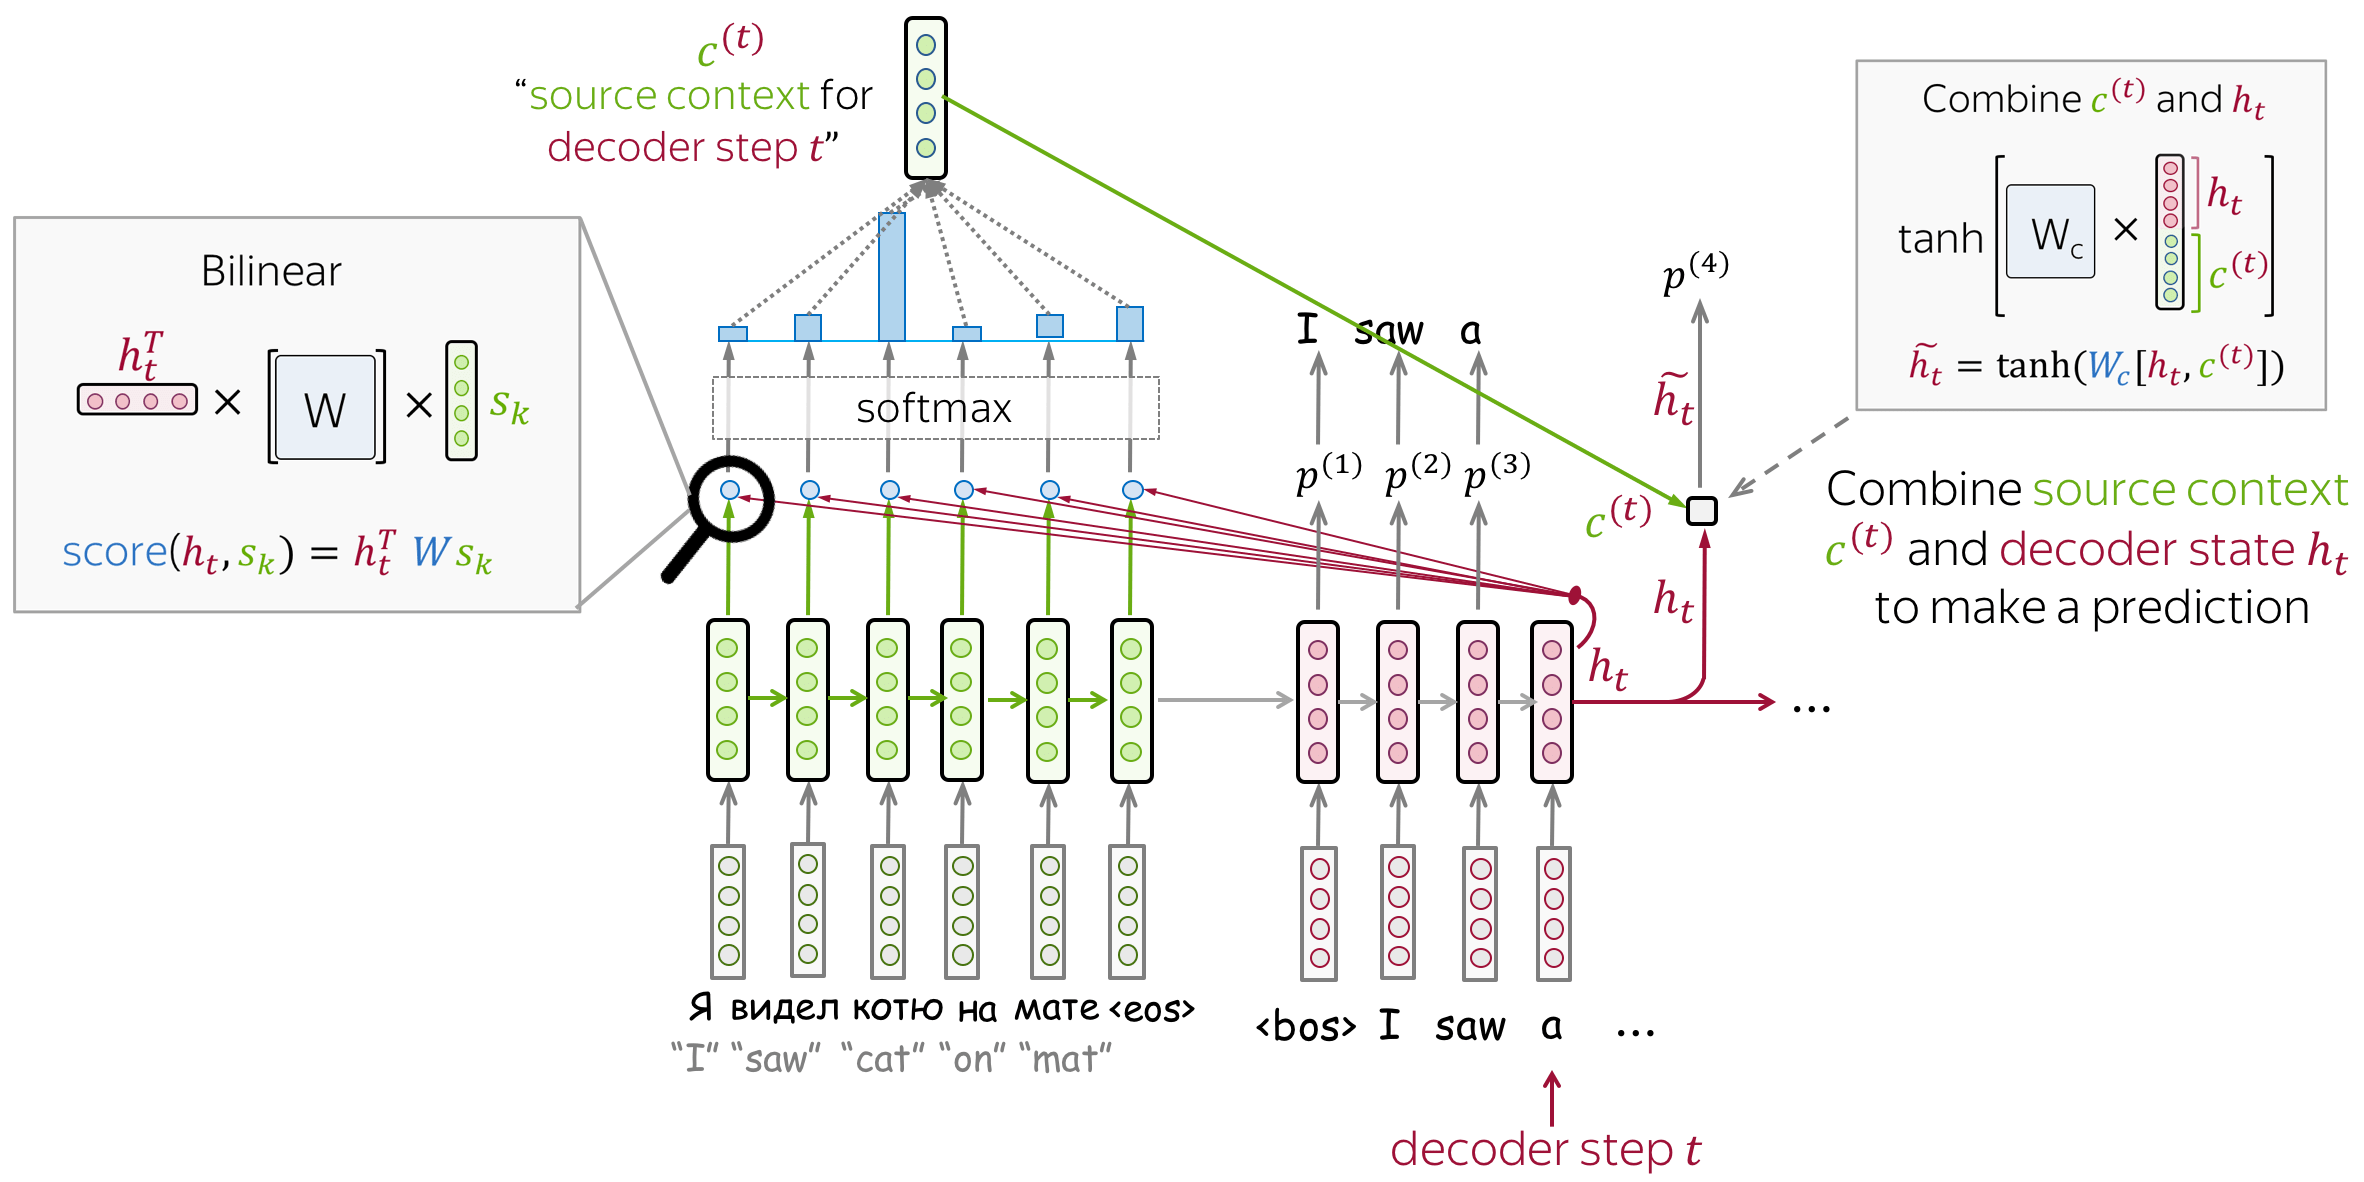

In [ ]:
class Seq2seqAttn(nn.Module):
    def __init__(self, fr_vocab_size, hidden_size, dropout_rate, embed_dim=None, en_vocab_size=None, en_pretrained=None, fr_pretrained=None):
        super().__init__()
        self.fr_vocab_size = fr_vocab_size
        self.dropout_rate = dropout_rate
        #encoder
        if en_pretrained is not None:
            embed_dim = 300
            self.enc_emb = nn.Embedding.from_pretrained(en_pretrained, freeze=False)
        else:
            self.enc_emb = nn.Embedding(en_vocab_size, embed_dim)
        self.encoder = nn.GRU(embed_dim, hidden_size, batch_first=True)
        #decoder
        if fr_pretrained is not None:
            self.dec_emb = nn.Embedding.from_pretrained(fr_pretrained, freeze=False)
        else:
            self.dec_emb = nn.Embedding(fr_vocab_size, embed_dim)
        self.decoder = nn.GRU(embed_dim, hidden_size, batch_first=True)
        #attention
        self.luong_score = nn.Linear(hidden_size, hidden_size, bias=False)
        self.luong_combine = nn.Linear(hidden_size*2, hidden_size, bias=False)
        self.fc = nn.Linear(hidden_size, fr_vocab_size)
    
    def forward(self, X, y):
        #encode
        #X (batch_size, seq_len)
        X = self.enc_emb(X) #batch_size, seq_len, embed_dim
        X =  F.dropout(X, p=self.dropout_rate, training=self.training)
        enc_out, h_enc = self.encoder(X) #enc_out (batch_size, seq_len, hidden_size); h_enc (1, batch_size, hidden_size)
        #decode
        #y (batch_size, seq_len)
        target = dataset.fr_vocab['<SOS>']*torch.ones(y.shape[0], dtype=int).to(device) #batch_size
        h_dec = h_enc #start with encoder hidden state
        #create array to store predictions (batch_size, seq_len, fr_vocab_size)
        outputs = torch.zeros(y.shape[0], y.shape[1], self.fr_vocab_size).to(device)
        for i in range(1, y.shape[1]):
            target = self.dec_emb(target).unsqueeze(1) #(batch_size, 1, embed_dim)
            target =  F.dropout(target, p=self.dropout_rate, training=self.training)
            #decoder
            dec_out, h_dec = self.decoder(target, h_dec) #dec_out (batch_size, 1, hidden_size)
            dec_out =  F.dropout(dec_out, p=self.dropout_rate, training=self.training)
            #attention
            #dec_out (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
            #Luong score (hidden_size, hidden_size)
            #dec_out @ Luong (batch_size, hidden_size) -> (batch_size, 1, hidden_size)
            #enc_out (batch_size, seq_len, hidden_size) -> (batch_size, hidden_size, seq_len)
            attn_score = torch.bmm(self.luong_score(dec_out.squeeze(1)).unsqueeze(1), enc_out.permute((0,2,1))) #batch_size, 1, seq_len
            #attn_score (batch_size, 1, seq_len) -> (batch_size, seq_len)
            attn_weight = F.softmax(attn_score.squeeze(1), dim=1) #(batch_size, seq_len)
            #attn_weight (batch_size, seq_len) -> (batch_size, 1, seq_len)
            attn_output = torch.bmm(attn_weight.unsqueeze(1), enc_out) #batch_size, 1, hidden_size
            #attn_output (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
            #dec_out (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
            attn_combined = self.luong_combine(torch.cat((attn_output.squeeze(1),dec_out.squeeze(1)), 1))
            attn_combined = torch.tanh(attn_combined) #batch_size, hidden_size
            #output
            output = F.log_softmax(self.fc(attn_combined), dim=1) #batch_size, fr_vocab_size
            #store output
            outputs[:,i,:] = output
            #teacher forcing
            target = y[:,i]
        return outputs
    
    @torch.no_grad()
    def translate_sentence(self, sent):
        #prepare sent
        sent = dataset._normalize_string(sent)
        sent = sent + ' <EOS>'
        sent = torch.tensor([dataset.en_vocab[word] for word in sent.split()])
        sent = sent.to(device)
        #encode
        #sent (seq_len,) -> (1, seq_len)
        X = self.enc_emb(sent.unsqueeze(0)) #1, seq_len, embed_dim
        enc_out, h_enc = self.encoder(X) #enc_out (1, seq_len, hidden_size); h_enc (1, 1, hidden_size)
        #decode
        #the first decoder input is the <sos> token
        target = torch.tensor(dataset.fr_vocab['<SOS>']).reshape(1,1).to(device)
        h_dec = h_enc #start with encoder hidden state
        outputs = []
        while target.item() != dataset.fr_vocab['<EOS>']:
            target = self.dec_emb(target) #1, 1, embed_dim
            #decoder
            dec_out, h_dec = self.decoder(target, h_dec) #dec_out (1, 1, hidden_size)
            #attention
            #dec_out (1, 1, hidden_size) -> (1, hidden_size)
            #Luong score (hidden_size, hidden_size)
            #dec_out @ Luong (1, hidden_size) -> (1, 1, hidden_size)
            #enc_out (1, seq_len, hidden_size) -> (1, hidden_size, seq_len)
            attn_score = torch.bmm(self.luong_score(dec_out.squeeze(1)).unsqueeze(1), enc_out.permute((0,2,1))) #1, 1, seq_len
            #attn_score (1, 1, seq_len) -> (1, seq_len)
            attn_weight = F.softmax(attn_score.squeeze(1), dim=1) #(1, seq_len)
            #attn_weight (1, seq_len) -> (1, 1, seq_len)
            attn_output = torch.bmm(attn_weight.unsqueeze(1), enc_out) #1, 1, hidden_size
            #attn_output (1, 1, hidden_size) -> (1, hidden_size)
            #dec_out (1, 1, hidden_size) -> (1, hidden_size)
            attn_combined = self.luong_combine(torch.cat((attn_output.squeeze(1),dec_out.squeeze(1)), 1))
            attn_combined = torch.tanh(attn_combined) #1, hidden_size
            #output
            output = F.log_softmax(self.fc(attn_combined), dim=1) #1, fr_vocab_size
            #decoder input for the next timestep is its output at the current timestep
            target = output.argmax(dim=1, keepdim=True) #1, 1
            outputs.append(target)
        return ' '.join(dataset.fr_vocab.lookup_tokens(outputs))

In [ ]:
#hyperparameters
num_epochs = 20
batch_size = 64
hunits = 512
dropout_rate = 0.5
lr = 0.001

#model
model = Seq2seqAttn(
    fr_vocab_size=len(dataset.fr_vocab),
    hidden_size=hunits,
    dropout_rate=dropout_rate,
    en_pretrained=en_pretrained,
    fr_pretrained=fr_pretrained
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    #training
    loss = fit(model, optimizer)
    train_losses.append(loss)
    #validation
    loss_val = evaluate(model, val)
    val_losses.append(loss_val)
    #epoch end
    print(f'********Epoch {epoch+1}********')
    print(f'Train loss: {loss:.2f};    Val loss {loss_val:.2f}\n')

#training end
print(f'Test loss: {evaluate(model, test):.2f}')
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
txt = 'the sun shines hot and the wind blows cold'
model.eval()
model.translate_sentence(txt)

In [ ]:
txt = 'have a good day'
model.translate_sentence(txt)

In [ ]:
for i in range(5):
    X, y = test[i]
    X = ' '.join(dataset.en_vocab.lookup_tokens(X.tolist()))
    y = ' '.join(dataset.fr_vocab.lookup_tokens(y.tolist()))
    print(f'English: {X}')
    print(f'French: {y}')
    print(f'Translation: {model.translate_sentence(X)}')
    print('\n*****************************************\n')